# 実践コンピュータビジョン
# 6章 画像のクラスタリング
## 6.1 k平均クラスタリング法
### 6.1.1 SciPyのクラスタリングパッケージ
テキストp.132

k平均法は簡単に実装できるが、SciPyのベクトル量子化パッケージscipy.cluster.vqを使えば、実装をしなくてもよい。<br>
まず2Dデータの例を見る。

テキストではｖｑモジュールをワイルドカードでimportしているが、モジュールを明確にするため、<br>

```python
from scipy.cluster import vq
```

としてimportする。

In [1]:
import numpy as np
from numpy import random
from scipy import linalg
from PIL import Image
import matplotlib.pyplot as plt
from scipy.cluster import vq
%matplotlib inline

### サンプルデータ
2つのクラスのデータを作り、1つの集合にまとめる。

In [2]:
# サンプルデータの入力
class1 = 1.5 * random.randn(100,2)
class2 = random.randn(100,2) + np.array([5,5])
features = np.vstack((class1,class2))

### k平均法のモデル作成
vq.kmeans()にデータとクラスタ数を入力して、モデルを作成する。<br>
出力は重心（centroid）と分散（variance）。

In [3]:
centroids,variance = vq.kmeans(features,2)
print(centroids)
print(variance)

[[-0.24290841 -0.08489525]
 [ 5.08707742  4.97298198]]
1.50492063973


### ベクトル量子化関数: scipy.cluster.vq.vq()

scipy.cluster.vq.vq()で、ベクトル量子化ができる。<br>
vqモジュール内にvq()関数があるというわかりにくい構造。<br>
http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.vq.html

In [4]:
# クラスタリングで分類した結果をcodeに返し、
# centroid（クラスター中心）からの距離をdistanceに返す
code,distance = vq.vq(features,centroids)

In [17]:
# データ数はいずれも200個
print(code.shape) # code = ラベル
print(distance.shape) # distance = データの距離

(200,)
(200,)


In [18]:
# 単純にvstackしただけなので、ラベル0と1が連続している。
code

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [19]:
# 2００個のデータのうち最初の１０個の距離を表示
distance[:10]

array([ 1.20293347,  3.04463398,  0.1693224 ,  2.774316  ,  2.17503017,
        1.29902155,  2.44537934,  0.40746392,  2.30398729,  1.95008196])

In [25]:
ndx = np.where(code==0)
type(ndx)

tuple

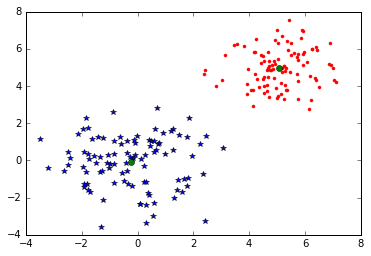

In [26]:
plt.figure()

# code=0に分類された点群
# np.where()の出力はtupleなので、ndxをarrayにするため、最後に[0]をつける
ndx = np.where(code==0)[0] 
plt.plot(features[ndx,0],features[ndx,1],'*')

# code=1に分類された点群
ndx = np.where(code==1)[0]
plt.plot(features[ndx,0],features[ndx,1],'r.')
plt.plot(centroids[:,0],centroids[:,1],'go')
# axis('off')
plt.show()

## 結果
(0,0)に中心があるクラスタと、(5,5)に中心があるクラスタの2つが表示された。<br>
前者の方が分散が大きい。

### 6.1.2 画像のクラスタリング
テキストp.133

「1.3.6 画像の主成分分析」で用いたアルファベットのフォント画像に対して、k平均法を適用する。

In [27]:
import imtools
import pickle

In [28]:
# 画像のリストを得る
imlist = imtools.get_imlist('selected_fontimages/')

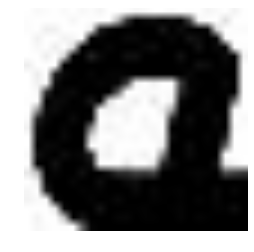

In [29]:
# 1つ目の画像ファイルを表示する
plt.imshow(Image.open(imlist[0]))
plt.gray()
plt.axis('off')
plt.show()

In [30]:
# imlist内のファイルの数を確認する
imnbr = len(imlist)
imnbr

66

In [31]:
# モデルのファイルを読み込む
with open('font_pca_modes.pkl','rb') as f:
    immean = pickle.load(f)
    V = pickle.load(f)

In [34]:
# 平板化した画像を格納する行列を作る
immatrix = np.array([np.array(Image.open(im)).flatten()
                  for im in imlist],'f')
immatrix.shape

(66, 625)

In [35]:
# 第40主成分までを射影する
immean = immean.flatten()
projected = np.array([np.dot(V[:40],immatrix[i]-immean)
                   for i in range(imnbr)])
immean.shape

(625,)

In [37]:
# k平均法
projected = vq.whiten(projected)
centroids,distortion = vq.kmeans(projected,4)

code,distance = vq.vq(projected,centroids)

code: 0


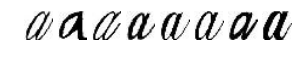

code: 1


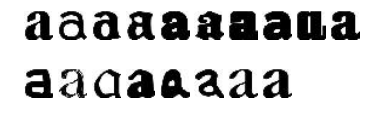

code: 2


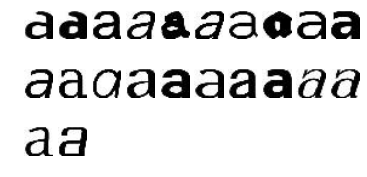

code: 3


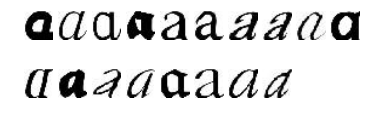

In [38]:
# クラスタを描画する
for k in range(4):
    print('code:',k)
    ind = np.where(code==k)[0]
    plt.figure()
    plt.gray()
    for i in range(np.minimum(len(ind),40)):
        plt.subplot(4,10,i+1)
        plt.imshow(immatrix[ind[i]].reshape((25,25)))
        plt.axis('off')
    plt.show()

### 6.1.3 画像の可視化
テキストp.134

主成分分析を用いて、2つの成分に絞って、クラスタリング結果を図示する。

In [39]:
from PIL import Image, ImageDraw

In [40]:
# Vの第1,2主成分を表示する
V[[0,1]]

array([[ 0.00045775,  0.00065163,  0.00036342, ...,  0.03277609,
         0.03043029,  0.02937886],
       [-0.00033921, -0.00035105, -0.00030379, ..., -0.01015186,
        -0.02131864, -0.03097396]], dtype=float32)

### 主成分へのデータの射影
主成分分析の行列Vに対して、テキストでは、第1軸と第3軸への射影を利用している。<br>
ここでは第１軸と第２軸へ射影する。

In [41]:
# 第1,2主成分を射影する
projected = np.array([np.dot(V[[0,1]],immatrix[i]-immean) 
                   for i in range(imnbr)])
# 第1,3主成分を射影する
#projected = array([dot(V[[0,2]],immatrix[i]-immean) 
#                   for i in range(imnbr)])

In [42]:
# k平均法
projected = vq.whiten(projected)
centroids,distortion = vq.kmeans(projected,4)

code,distance = vq.vq(projected,centroids)

In [43]:
# 高さと幅
h,w = 1200,1200

# 白の背景で新しい画像を生成する
img = Image.new('RGB',(w,h),(255,255,255))
draw = ImageDraw.Draw(img)

# 軸を描画する
draw.line((0,h/2,w,h/2),fill=(255,0,0))
draw.line((w/2,0,w/2,h),fill=(255,0,0))

In [44]:
# 軸のスケールを調整する
scale = abs(projected).max(0)
scaled = np.floor(np.array([ (p / scale) * (w/2-20,h/2-20) +
                       (w/2,h/2) for p in projected]))

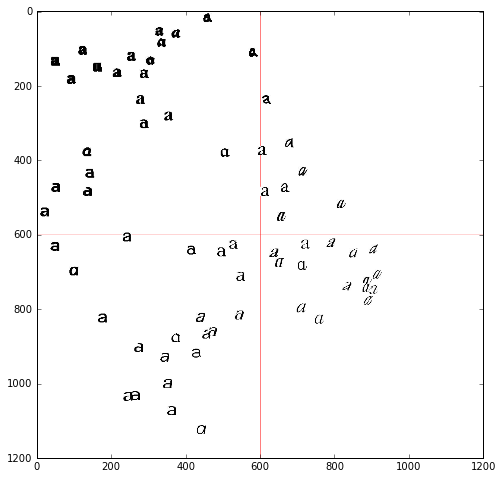

In [47]:
# 各画像のサムネイルを貼り付ける
for i in range(imnbr):
    nodeim = Image.open(imlist[i])
    nodeim.thumbnail((25,25))
    ns = nodeim.size
    img.paste(nodeim,(int(scaled[i][0]-ns[0]//2),int(scaled[i][1]-ns[1]//2),
                      int(scaled[i][0]+ns[0]//2)+1,int(scaled[i][1]+ns[1]//2)+1))

img.save('data/pca_font.jpg')

plt.figure(figsize=(8,8))
plt.imshow(np.array(img))
# plt.axis('off')
plt.show()

### 6.1.4 ピクセルのクラスタリング

In [48]:
from scipy.misc import imresize

### (1) エンパイア・ステートビルの画像
おなじみのempire.jpgのピクセルをクラスタリングする

In [49]:
# 画像は steps*steps の領域に分割される
steps = 100 
im = np.array(Image.open('data/empire.jpg'))

dx = im.shape[0] / steps
dy = im.shape[1] / steps

In [50]:
dx

8.0

In [51]:
# 各領域の色特徴量を計算する
features = []
for x in range(steps):
    for y in range(steps):
        R = np.mean(im[x*dx:(x+1)*dx, y*dy:(y+1)*dy,0])
        G = np.mean(im[x*dx:(x+1)*dx, y*dy:(y+1)*dy,1])
        B = np.mean(im[x*dx:(x+1)*dx, y*dy:(y+1)*dy,2])
        features.append([R,G,B])
features = np.array(features,'f') # 配列に入れる

In [52]:
# クラスタリング
centroids,variance = vq.kmeans(features,3)
code,distance = vq.vq(features,centroids)

# クラスタのラベルを使って画像を生成する
codeim = code.reshape(steps,steps)
codeim = imresize(codeim,im.shape[:2],interp='nearest')

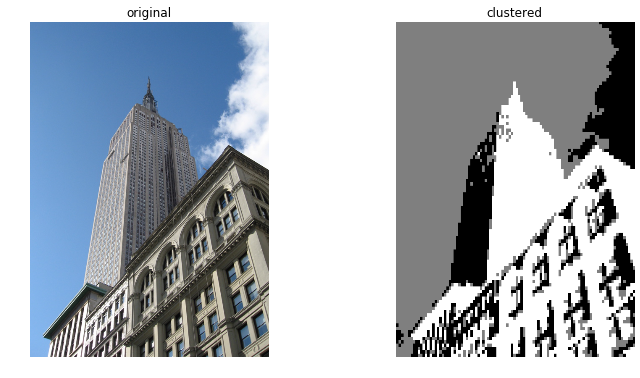

In [54]:
tlist = ['original', 'clustered']
imagelist = [im, codeim]
plt.figure(figsize=(12,6))
plt.gray()
for i, image, title in zip(range(2), imagelist, tlist):
    plt.subplot(1,2,i+1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title)
plt.savefig('data/cluster_empire.png')
plt.show()

### (2) 丘の上の少年
少年が写った風景画のクラスタリング。

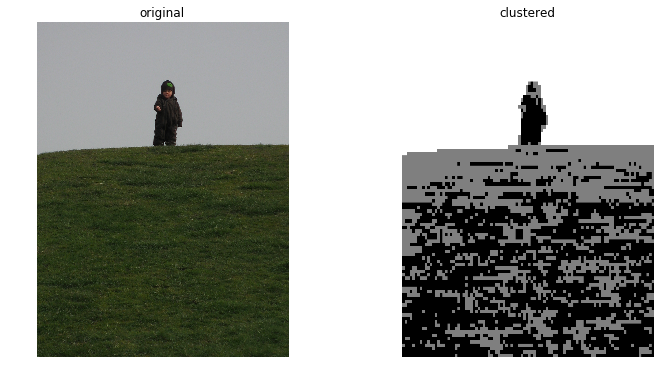

In [55]:
# 画像は steps*steps の領域に分割される
steps = 100 
im = np.array(Image.open('data/boy_on_hill.jpg'))

dx = im.shape[0] / steps
dy = im.shape[1] / steps

# 各領域の色特徴量を計算する
features = []
for x in range(steps):
    for y in range(steps):
        R = np.mean(im[x*dx:(x+1)*dx, y*dy:(y+1)*dy,0])
        G = np.mean(im[x*dx:(x+1)*dx, y*dy:(y+1)*dy,1])
        B = np.mean(im[x*dx:(x+1)*dx, y*dy:(y+1)*dy,2])
        features.append([R,G,B])
features = np.array(features,'f') # 配列に入れる

# クラスタリング
centroids,variance = vq.kmeans(features,3)
code,distance = vq.vq(features,centroids)

# クラスタのラベルを使って画像を生成する
codeim = code.reshape(steps,steps)
codeim = imresize(codeim,im.shape[:2],interp='nearest')

tlist = ['original', 'clustered']
imagelist = [im, codeim]
plt.figure(figsize=(12,6))
plt.gray()
for i, image, title in zip(range(2), imagelist, tlist):
    plt.subplot(1,2,i+1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title)
plt.savefig('data/cluster_boy_on_hill.png')
plt.show()